# 0. Import Packages and Load Data

In [36]:
# Basics
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# power analysis
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
import statsmodels.api as sm

# regression
import statsmodels.formula.api as smf
import statsmodels.api as sm 

In [37]:
rg_df = pd.read_csv('RestaurantGrades Data.csv')

# 1. Exploratory Data Analysis

In [38]:
# see data
rg_df.head()

,Restaurant_Number,Page_Views,Calls,Reservations,Stars_PreExperiment,Chain,Treatment_Arm
0,1,347,57,48,5.0,0,0
1,2,138,26,26,4.5,0,1
2,3,523,77,67,5.0,0,2
3,4,111,7,23,3.5,0,2
4,5,313,26,32,4.0,0,1


## 1a. Data Cleaning

In [39]:
# check for missing data
rg_df.isna().sum()

Restaurant_Number      0
Page_Views             0
Calls                  0
Reservations           0
Stars_PreExperiment    0
Chain                  0
Treatment_Arm          0
dtype: int64

In [40]:
# drop unnecessary columns
rg_df = rg_df.drop('Restaurant_Number',axis=1)

## 1b. Distribution

First, we take a look at the distribution of stars and chain in the entire experiment sample.
Aim of this EDA is to contextualize the hypothesis test results by familiarizing with data and to see if data contains outliers. 

In [41]:
def plot_bar(data, variable,title):
    x_axis = data[variable].value_counts().sort_index().index
    y_axis = data[variable].value_counts().sort_index().values

    plt.figure(figsize=(5,7))
    plt.bar(x_axis,y_axis,width=0.3,align='center')
    plt.title(title)
    plt.show()

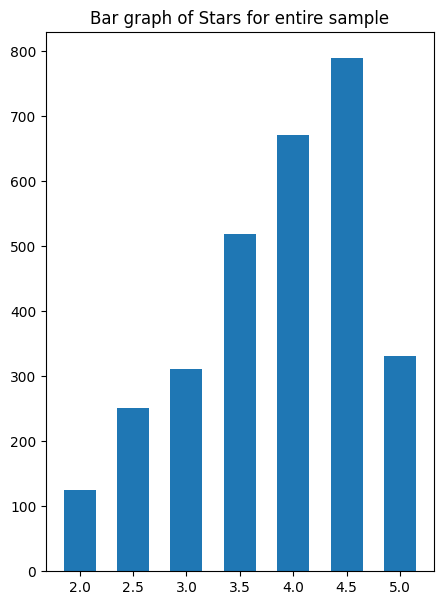

In [42]:
plot_bar(data=rg_df,variable='Stars_PreExperiment',title='Bar graph of Stars for entire sample')


In [43]:
def plot_box(data,variable,title):
    plt.boxplot(data[variable])
    plt.ylabel('Review in Stars')
    plt.title(title)
    plt.show()

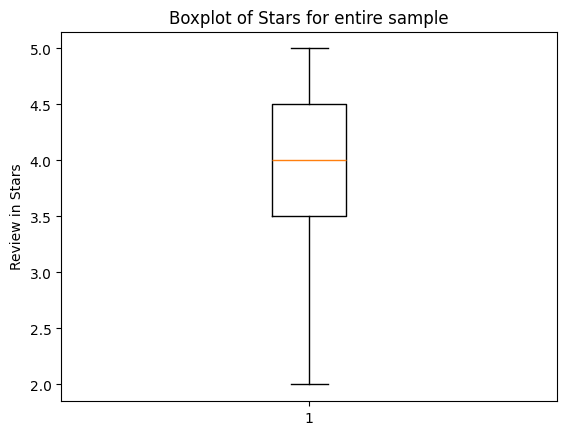

In [44]:
plot_box(rg_df,'Stars_PreExperiment',title = 'Boxplot of Stars for entire sample')

We see from the bar plot, that the distribution of stars in the entire sample is left skewed and most restaurants have 4.5 stars, followed by 4.0 and 3.5. From the box plot, we see that the median is 4 and most restaurants are within 3.5 (1Q) to 4.5 (3Q) range. There are no outliers.

Now, we look at the distribution per experiment group.

In [45]:
control = rg_df[rg_df['Treatment_Arm'] == 0]
treatment1 = rg_df[rg_df['Treatment_Arm'] == 1]
treatment2 = rg_df[rg_df['Treatment_Arm'] == 2]

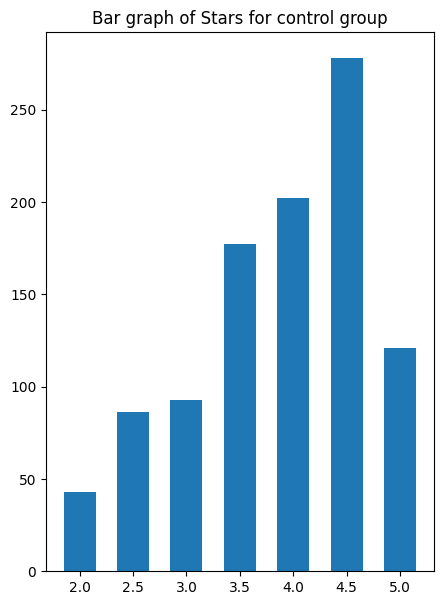

In [46]:
plot_bar(control,'Stars_PreExperiment',title='Bar graph of Stars for control group')

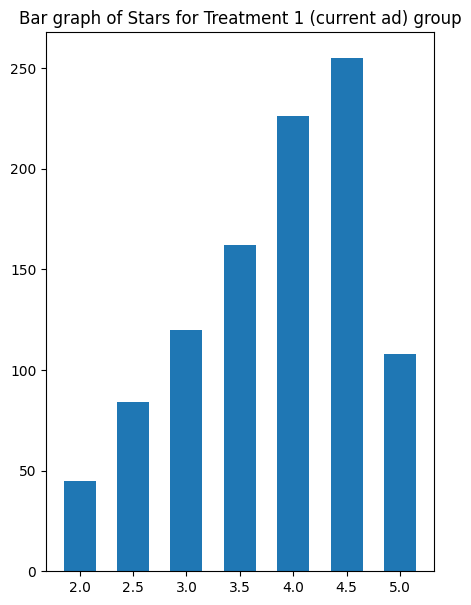

In [47]:
plot_bar(treatment1,'Stars_PreExperiment',title='Bar graph of Stars for Treatment 1 (current ad) group')

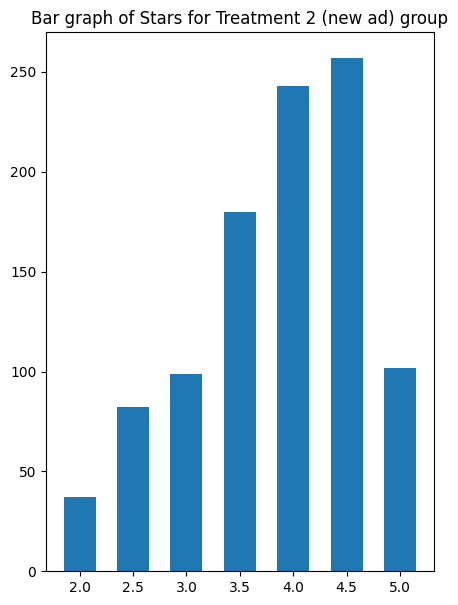

In [48]:
plot_bar(treatment2,'Stars_PreExperiment',title='Bar graph of Stars for Treatment 2 (new ad) group')

We can see that the distribution of the stars is similar across all three groups. This means that our sample successfully randomized for this variable. We will conduct balance check later on to test if this variable is statistically randomized across all three groups.

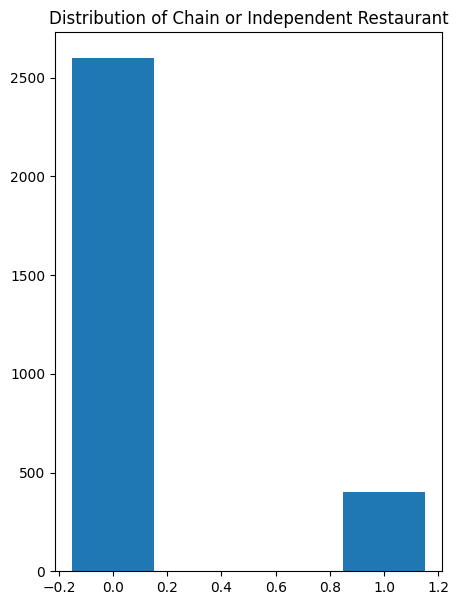

In [49]:
plot_bar(rg_df,'Chain','Distribution of Chain or Independent Restaurant')

# 2. Precision and Power Analysis

**Significance Level**

RG is willing to accept 10% risk of falsely concluding that the new ad design increases 

**Power**

Power is 1 - beta.

Beta is type 2 error, probability of failing to detect a true effect when it exists. 

We set beta to 0.2, so we want 80% probability of detecting a true effect.

**Minimum Detectable Effect**

The "average" ads lift for restaurants isn't a single number and depends on many other characteristics, but research show potential lifts of 14% to 20% in store visits and brand awareness due to ads. 

Thus, RG would want to detect at least 20% improvement of the reservations with statistical significance.



In [50]:
alpha = 0.1
power = 0.8
mde = 0.2 

# proportions
p1 = 0.20 
p2 = p1 * (1 + 0.2)

In [59]:
# calculate effect size
cohen_D = sm.stats.proportion_effectsize(p1, p2)

# estimate required sample size 
n = tt_ind_solve_power(effect_size=cohen_D, power=power, alpha=alpha)
n = int(round(n, -3)) 

print(f'To detect lift of {100*(p2/p1-1):.1f}%, the sample size per group required is {n}.')


To detect lift of 20.0%, the sample size per group required is 1000.


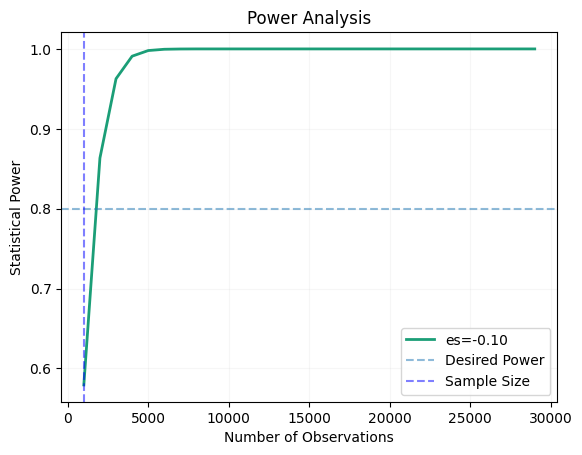

In [58]:
# Explore power across sample sizes
ttest_power = TTestIndPower()
ttest_power.plot_power(dep_var='nobs', nobs=np.arange(1000,30000,1000), effect_size=[cohen_D], title='Power Analysis')

# Set plot parameters
plt.axhline(0.8, linestyle='--', label='Desired Power', alpha=0.5)
plt.axvline(n, linestyle='--', color='blue', label='Sample Size', alpha=0.5)
plt.ylabel('Statistical Power')
plt.grid(alpha=0.1)
plt.legend()
plt.show()